In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import time
import imageio.v3 as iio
import pandas as pd
import os
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras

# Neural Network Models

After an initial and not really successful exploration with simpler models, we will now focus on training neural networks to classify SETI signals from spectrogram images.
Neural networks are highly effective machine learning models capable of capturing complex patterns in data, making them well-suited for the analysis of SETI signals, which often contain intricate and noisy patterns.
To classify these SETI signals, we will employ deep learning techniques leveraging some of the most prominent architectures in image classification, such as Convolutional Neural Networks (CNNs).

In this multi-class image classification problem, the goal is to train a model that can correctly identify the class of each SETI signal. There are seven distinct signal types, and the model must learn to classify each input image into one of these seven categories based on the unique characteristics of the spectrogram data.

Each class is represented with an index followed by the class named:
~~~
class_names = ["brightpixel", "narrowband", "narrowbanddrd", "noise", "squarepulsednarrowband", "squiggle", "squigglesquarepulsednarrowband"]
~~~

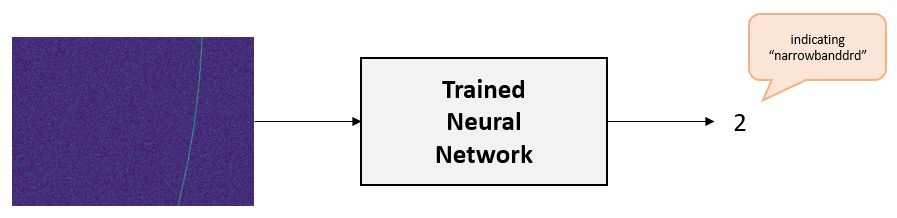


A neural network has several hidden layers to extract (“learn”) features from the images. The very last layer is the one that classifies the image. In this case, we are classifying seven classes (seven signal types). Therefore the last layer has seven neurons, one for each type.
And because we want to know what type of signal is represented, we use softmax activation in the last layer to give us a probability distribution of each type.

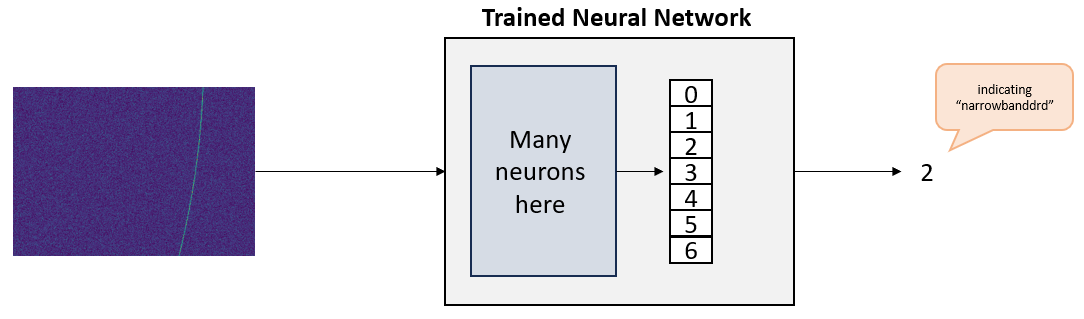


## Transfer Learning
One of the most effective strategies for improving the performance of neural network models is transfer learning. This method involves leveraging a pre-trained model as a starting point and fine-tuning it on a new dataset tailored for a specific task. By utilizing the knowledge and features learned by the pre-trained model, we can accelerate the training process, enhance the model’s performance, and achieve better results for our application.

For our implementation, at first we are utilizing the ImageNet dataset, a large and comprehensive collection of over 14 million images across more than 20,000 categories. ImageNet is renowned for its high-quality, diverse images, making it an excellent resource for training deep learning models. Models pre-trained on ImageNet have already learned rich feature representations, which are crucial for effective image analysis.

In the context of our SETI task, which involves classifying signals into 7 distinct classes, leveraging pre-trained models is especially beneficial. The complexity and diversity of the signals require a model that can effectively extract features and recognize patterns across multiple classes. Transfer learning allows us to utilize the extensive feature representations learned from ImageNet, which can translate well to the nuances in our SETI dataset.

For our transfer learning process, we will utilize some pre-trained models and proceed with fine-tuning. We will load the chosen base model and replace the final fully connected layer with a new layer that outputs the 7 classes relevant to our task.
In Addition, we will unfreeze some of the last layers for some fine-tuning for better adaptation to our dataset. 
By focusing on the final layers, we ensure that the model is specifically tuned for distinguishing between the 7 classes of SETI signals.

At first we will start with **ResNet50** which is widely used for various computer vision tasks, including image classification.

To start we need to prepare our image datasets:

In [112]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess dataset

def get_generated_data(base_path='/kaggle/input/seti-data', data_aug=False, img_height=224, img_width=224, batch_size=32):
    train_data_dir = f'{base_path}/primary_small/train/'
    valid_data_dir = f'{base_path}/primary_small/valid/'
    test_data_dir = f'{base_path}/primary_small/test/'
    
    valid_data_gen = ImageDataGenerator(rescale=1.0/255)
    test_data_gen = ImageDataGenerator(rescale=1.0/255)
    if data_aug:
        train_data_gen = ImageDataGenerator(
            rescale=1.0/255,
            brightness_range=[0.5, 1.5],
            horizontal_flip=True,
            channel_shift_range=20,
            vertical_flip=True,
        )
    else:
        train_data_gen = ImageDataGenerator(rescale=1.0/255)
        
    train_generator = train_data_gen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    valid_generator = valid_data_gen.flow_from_directory(
        valid_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_data_gen.flow_from_directory(
        test_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, valid_generator, test_generator


The get_generated_data function is designed to prepare image datasets for training, validation, and testing of a deep learning model using Keras. It utilizes the **ImageDataGenerator** class from TensorFlow's Keras API to load images from directories and apply optional data augmentation techniques. It's important to note that while the **ImageDataGenerator** applies data augmentation, it does not add new images to the dataset. Instead, during each epoch, it generates slightly altered versions of the existing images. This means that the model will encounter different images in each epoch, though the variations will not be drastic.

In our configuration, we enable several types of data augmentation techniques specifically for the training set:
* **brightness_range=[0.5, 1.5]:** This parameter allows for random adjustments to the brightness of the images within the specified range. A value of 0.5 indicates that the image can be made 50% darker, while a value of 1.5 allows it to become 50% brighter. This helps the model become more robust to variations in amplitude or power changes within the samples.  
* **horizontal_flip=True:** This augmentation randomly flips the images horizontally. In our samples, this flip does not alter the content significantly, as it only changes the direction of the signal without affecting its characteristics.  
* **channel_shift_range=20:** This parameter randomly shifts the color channels (R, G, B) of the images by a specified range. A value of 20 allows each channel to be adjusted by ±20 units. This can help the model learn to handle slight color variations due to different imaging conditions, potentially improving generalization across datasets with varying color properties.
* **vertical_flip=True:** This augmentation randomly flips the images vertically. Similar to horizontal flipping, this introduces additional variance into the training dataset, which may enhance the model's ability to generalize.

Additionally we apply the **rescale=1.0/255**. This parameter normalizes the pixel values of all images (training, validation, and test sets) from a range of 0-255 to a range of 0-1. This scaling helps improve model performance by ensuring that the input data is on a similar scale, which can lead to faster convergence during training.

In [113]:
train_generator, valid_generator, test_generator = get_generated_data()

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [114]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization

# Load the ResNet50 model with pretrained weights from ImageNet
# Exclude the top layers (include_top=False) to add custom layers for our task
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to use it as a feature extractor
base_model.trainable = False

# Unfreeze the last few layers of the pretrained model
for layer in base_model.layers[-10:]:
    layer.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The model will consist of an input layer following with the ResNet50 model, then a layer of GlobalAveragePooling2D as it helps maintain the number of parameters manageable, followed by a ReLU activation function, a BatchNormalization layer, and finally a softmax in the output layer of the model. 
We will use the `categorical_crossentropy` loss function to measures the dissimilarity between the true class labels and the predicted probabilities generated by the model, and the Adam optimizer to update the models parameters during training.

In [115]:
# Use base_model.output to get the output of the base model
x = base_model.output

# Add global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(2048, activation='relu')(x)

# Add batch normalization
x = BatchNormalization()(x)

# Output layer for 7 classes (for your SETI task)
output = Dense(7, activation='softmax')(x)

# Create the model
resnet50_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
resnet50_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
resnet50_model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_15[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 27,806,599 (106.07 MB)

 Trainable params: 8,680,455 (33.11 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

Before proceeding with our model training, we will introduce both **EarlyStopping** and **ReduceLROnPlateau**. Together, these callbacks can enhance the training process by preventing overfitting (through EarlyStopping) and allowing the model to adapt its learning rate dynamically for improved performance (through ReduceLROnPlateau).

The **EarlyStopping** callback is used to stop the training process when the model's performance on the validation set stops improving. This is particularly useful for preventing overfitting, where a model learns the training data too well but performs poorly on unseen data. Importantly, it also helps save time by halting the training when there is no improvement.

The **ReduceLROnPlateau** callback reduces the learning rate when a monitored metric has stopped improving. This can be particularly useful when the training process has plateaued, as a smaller learning rate may help the model fine-tune its weights and improve performance.

In [116]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

In [117]:
start_time = time.time()

history = resnet50_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
training_time = end_time - start_time
print(f'Model training time was: {training_time}')

Epoch 1/20


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 384ms/step - accuracy: 0.3323 - loss: 1.7200 - val_accuracy: 0.1429 - val_loss: 4.0196 - learning_rate: 1.0000e-04
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 345ms/step - accuracy: 0.4161 - loss: 1.5271 - val_accuracy: 0.1429 - val_loss: 7.7461 - learning_rate: 1.0000e-04
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 345ms/step - accuracy: 0.4464 - loss: 1.4546 - val_accuracy: 0.1429 - val_loss: 9.3065 - learning_rate: 1.0000e-04
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 346ms/step - accuracy: 0.4568 - loss: 1.4368 - val_accuracy: 0.1443 - val_loss: 12.7683 - learning_rate: 1.0000e-04
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 66s 364ms/step - accuracy: 0.4757 - loss: 1.3859 - val_accuracy: 0.1429 - val_loss: 13.4927 - learning_rate: 5.0000e-05
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 343ms/step - accuracy: 0.4822 - loss: 1.3531 - val_accuracy: 0.1429 - val_loss: 13.9597 - learning_rate: 5.0000e-05
Model training time was: 418.87967467308044


It appears that the training process was halted after just 6 out of the 20 planned epochs, as there was no improvement observed in both the validation loss and validation accuracy.

Although the current accuracy metrics may appear inadequate, it is crucial to assess the model's performance within a practical context, as well as to consider more specific evaluation metrics such as precision and recall.

In [118]:
def plot_predictions(model, test_generator, amount=8, images_per_row=4, 
                     class_names=["brightpixel", "narrowband", "narrowbanddrd", "noise", 
                                  "squarepulsednarrowband", "squiggle", "squigglesquarepulsednarrowband"]):
    # Calculate the number of rows needed
    num_rows = amount // images_per_row + (amount % images_per_row != 0)

    # Plot the specified number of samples
    plt.figure(figsize=(20, num_rows * 4))

    # Adjust layout for padding
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    for i in range(amount):
        # Randomly pick a batch index
        random_batch_idx = np.random.randint(0, len(test_generator))
        
        # Get the random batch
        X_batch, y_batch = test_generator[random_batch_idx]

        # Randomly pick an image index from the selected batch
        random_img_idx = np.random.randint(0, X_batch.shape[0])

        # Get the image and label
        X_img, y_label = X_batch[random_img_idx], y_batch[random_img_idx]

        # Get predictions for the batch
        predictions = model.predict(X_batch)

        # Convert predictions to class labels
        predicted_classes = np.argmax(predictions, axis=1)

        # Get the predicted class of the selected image
        predicted_label = predicted_classes[random_img_idx]
        true_label = np.argmax(y_label)

        # Plot the image
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(X_img)
        
        # Set title and labels
        title = f"Pred: {class_names[predicted_label]}\nTrue: {class_names[true_label]}"
        plt.title(title)
        plt.axis("off")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


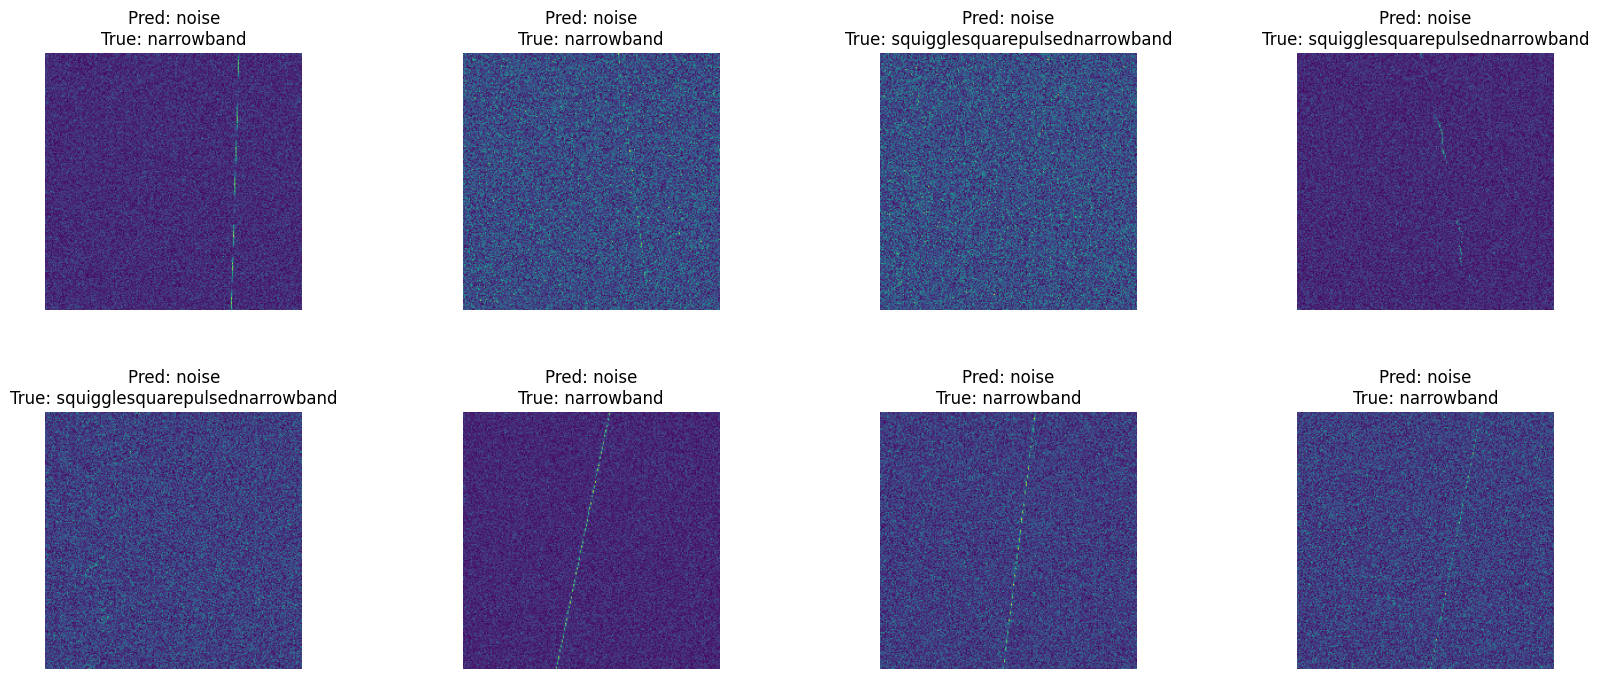

In [119]:
plot_predictions(model=resnet50_model, test_generator=test_generator)

It looks like the model classifies all of the signals as `noise` which is of course not the case here.  
Lets try to understand what is going on here by visualizing the training and validation loss curves of our model.

In [ ]:
def plot_losses(history):
    # Visualize training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss',linestyle='dashed')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

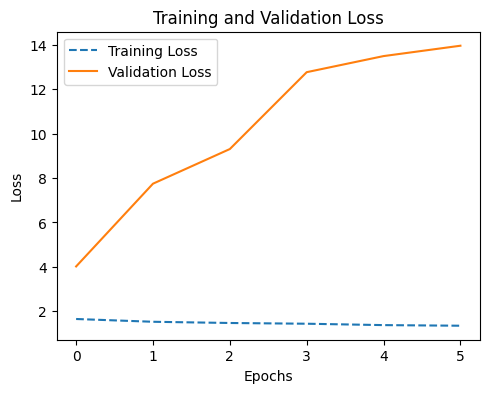

In [120]:
plot_losses(history)

The training loss exhibits a slight decrease, whereas the validation loss shows an upward trend. This pattern may suggest potential overfitting in our model, warranting further investigation and possible remediation.

Before addressing this issue, we will analyze the Confusion Matrix. This tool provides a comprehensive insight into our model's performance by revealing how well it performs across different classes, as well as identifying specific instances where the model may struggle or become confused.

In [126]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matix(model, test_generator, class_names=["brightpixel", "narrowband", "narrowbanddrd", "noise", "squarepulsednarrowband", "squiggle", "squigglesquarepulsednarrowband"]):
    # Confusion Matrix
    test_preds = model.predict(test_generator)
    test_preds_classes = np.argmax(test_preds, axis=1)
    test_true_classes = test_generator.classes
    cm = confusion_matrix(test_true_classes, test_preds_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[i] for i in range(7)], yticklabels=[class_names[i] for i in range(7)])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step


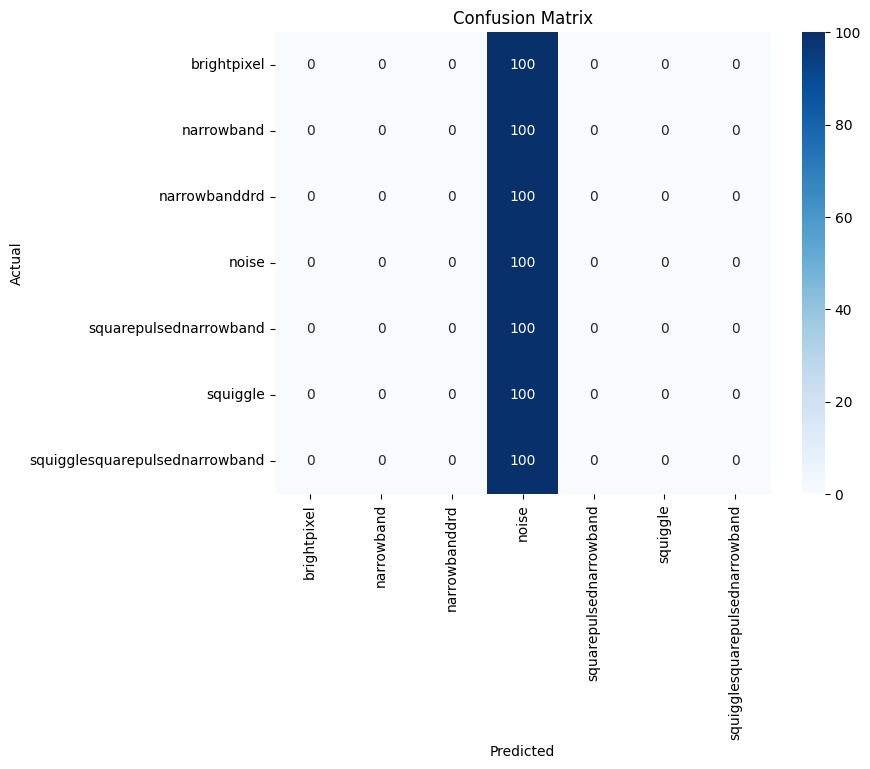

In [125]:
plot_confusion_matix(model=resnet50_model, test_generator=test_generator)

And as we have assumed before, the model classifies **ALL** of the signals as `noise`, and it seems like this model is just useless.


In [132]:
from sklearn.metrics import classification_report

def print_classifiaciton_report(model, test_generator):
    test_preds = model.predict(test_generator)
    test_preds_classes = np.argmax(test_preds, axis=1)
    test_true_classes = test_generator.classes
    
    report = classification_report(test_true_classes, test_preds_classes, output_dict=True)

    # Convert the dictionary to a pandas DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Optional: Round the metrics to 2 decimal places for better readability
    report_df = report_df.round(2)

    # Display the DataFrame
    print(report_df)

In [123]:
print_classifiaciton_report(model=resnet50_model, test_generator=test_generator)

22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 461ms/step
              precision  recall  f1-score  support
0                  0.00    0.00      0.00   100.00
1                  0.00    0.00      0.00   100.00
2                  0.00    0.00      0.00   100.00
3                  0.14    1.00      0.25   100.00
4                  0.00    0.00      0.00   100.00
5                  0.00    0.00      0.00   100.00
6                  0.00    0.00      0.00   100.00
accuracy           0.14    0.14      0.14     0.14
macro avg          0.02    0.14      0.04   700.00
weighted avg       0.02    0.14      0.04   700.00


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


The model's performance metrics are also very disappointing, we can undertand from the above report that our model seems to heavily favor class 3, achieving perfect recall for it, while failing completely on the other classes.  
So what's next? Before giving up on ResNet50 lets try something else, lets try to run the same model applying our data augmentation to exposed the model to a more diversed training examples.

In [127]:
train_generator, valid_generator, test_generator = get_generated_data(data_aug=True)

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


Now we will construct the model once again.

In [130]:
# Load the ResNet50 model with pretrained weights from ImageNet
# Exclude the top layers (include_top=False) to add custom layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to use it as a feature extractor
base_model.trainable = False

# Unfreeze the last few layers of the pretrained model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Use base_model.output to get the output of the base model
x = base_model.output

# Add global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(2048, activation='relu')(x)

# Add batch normalization
x = BatchNormalization()(x)

# Output layer for 7 classes (for your SETI task)
output = Dense(7, activation='softmax')(x)

# Create the model
resnet50_model_with_data_aug = Model(inputs=base_model.input, outputs=output)

# Compile the model
resnet50_model_with_data_aug.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Compile the model
resnet50_model_with_data_aug.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Let's train the model and hopefully it gets any better.

In [131]:
start_time = time.time()

history = resnet50_model_with_data_aug.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
training_time = end_time - start_time
print(f'Model training time was: {training_time}')

Epoch 1/20


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


175/175 ━━━━━━━━━━━━━━━━━━━━ 107s 514ms/step - accuracy: 0.2780 - loss: 1.8759 - val_accuracy: 0.1557 - val_loss: 2.2543 - learning_rate: 1.0000e-04
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 460ms/step - accuracy: 0.3588 - loss: 1.6860 - val_accuracy: 0.1429 - val_loss: 3.4170 - learning_rate: 1.0000e-04
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 452ms/step - accuracy: 0.3584 - loss: 1.6487 - val_accuracy: 0.1429 - val_loss: 6.6213 - learning_rate: 1.0000e-04
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 448ms/step - accuracy: 0.3749 - loss: 1.6264 - val_accuracy: 0.1429 - val_loss: 17.7322 - learning_rate: 1.0000e-04
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 80s 441ms/step - accuracy: 0.3953 - loss: 1.5896 - val_accuracy: 0.2057 - val_loss: 4.5486 - learning_rate: 5.0000e-05
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 80s 443ms/step - accuracy: 0.3989 - loss: 1.5599 - val_accuracy: 0.1429 - val_loss: 6.3553 - learning_rate: 5.0000e-05
Model training time was: 514.6092298030853


Unfortunately, the results indicate that this model does not show any improvement. However, we should validate our findings through visual representations of the predictions and by analyzing relevant metrics.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


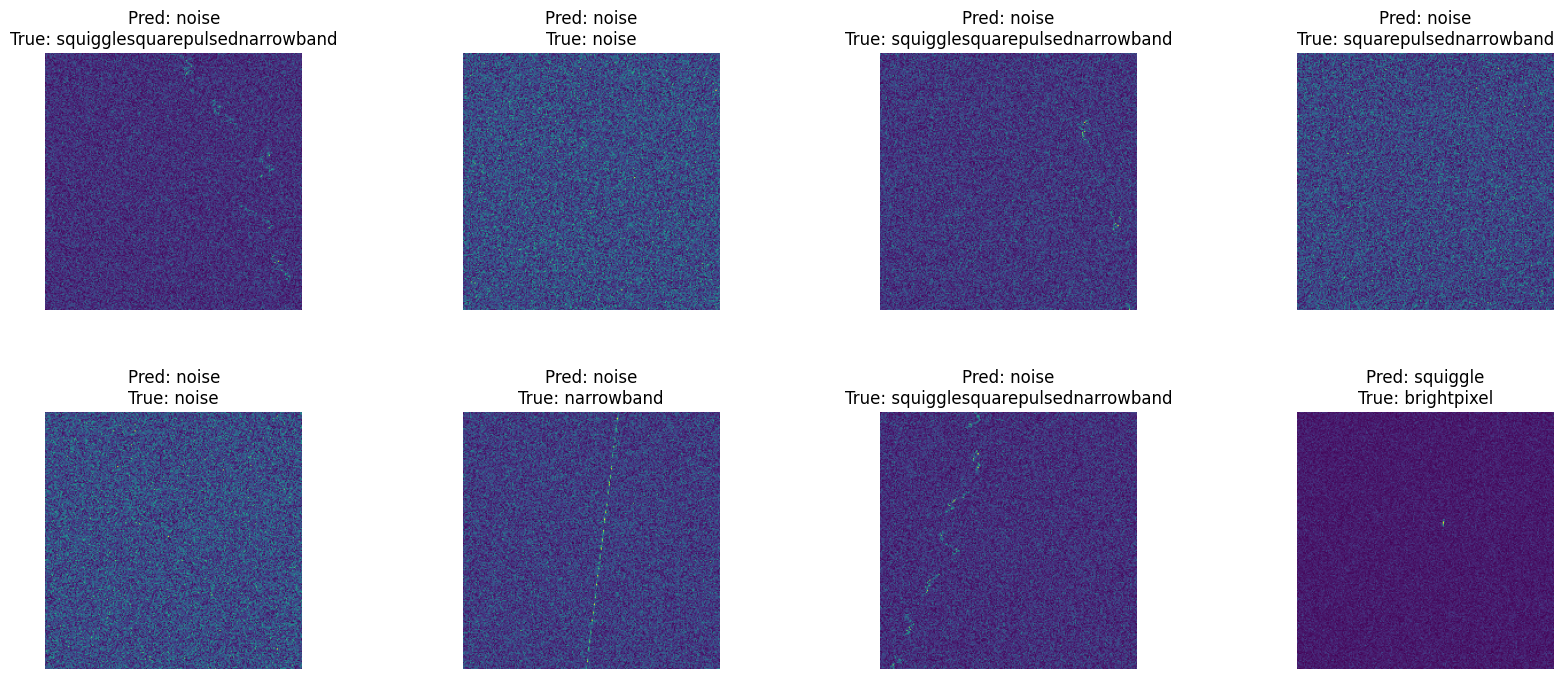

In [133]:
plot_predictions(model=resnet50_model_with_data_aug, test_generator=test_generator)

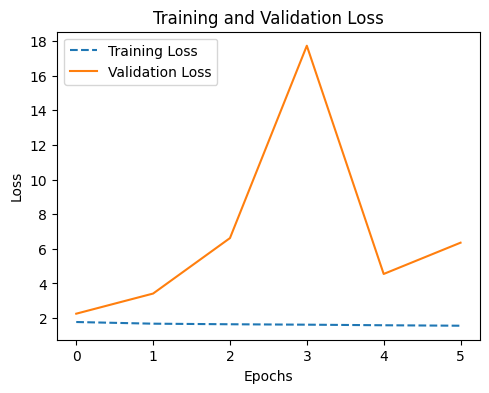

In [134]:
plot_losses(history)

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step


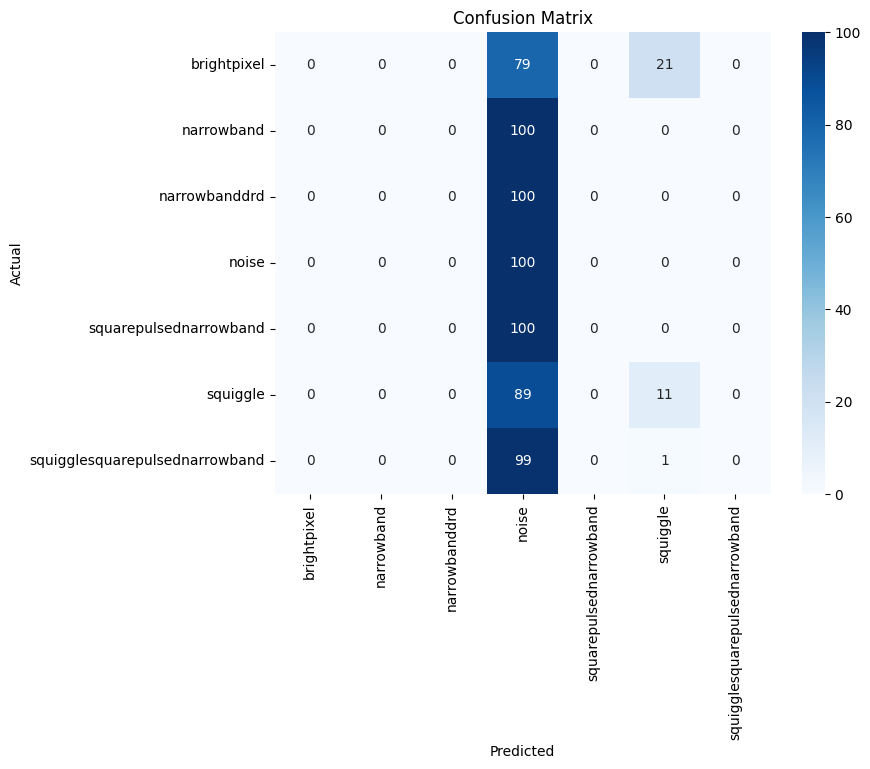

In [136]:
plot_confusion_matix(model=resnet50_model_with_data_aug, test_generator=test_generator)

In [135]:
print_classifiaciton_report(model=resnet50_model_with_data_aug, test_generator=test_generator)

22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 511ms/step
              precision  recall  f1-score  support
0                  0.00    0.00      0.00   100.00
1                  0.00    0.00      0.00   100.00
2                  0.00    0.00      0.00   100.00
3                  0.15    1.00      0.26   100.00
4                  0.00    0.00      0.00   100.00
5                  0.33    0.11      0.17   100.00
6                  0.00    0.00      0.00   100.00
accuracy           0.16    0.16      0.16     0.16
macro avg          0.07    0.16      0.06   700.00
weighted avg       0.07    0.16      0.06   700.00


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Unfortunately, it seems that our efforts didn't lead to any improvement. The issue might be related to either our model or the amount of training data we have. Even though we used data augmentation, it’s important to remember that `ImageDataGenerator` doesn’t actually add new data to the existing training samples, as we've discussed before.

When it comes to the ResNet18 model, which was trained on the ImageNet dataset, we should keep in mind that it includes millions of images from thousands of classes, such as animals, objects, and scenes. This wide-ranging training may not be relevant for our task of classifying SETI signals, which could explain the model's poor performance.

For these reasons, we’ve decided to take a closer look at pre-trained models that are better suited for time-series data, like **WaveNet** or **VGGish**. Specifically for spectrogram classification or tasks related to SETI signal detection, **VGGish** is likely a better fit since it’s designed for spectrograms. On the other hand, **WaveNet** is more geared toward generating and modeling raw audio sequences. So, we’ll give **VGG16** a try.



In [16]:
train_generator, valid_generator, test_generator = get_generated_data()

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


We will configure the VGG16 as our base_model and unfreeze the last 10 layers for some flexibility of the model same as done before.

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model with pretrained weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to use it as a feature extractor
base_model.trainable = False

# Unfreeze the last few layers of the pretrained model
for layer in base_model.layers[-10:]:
    layer.trainable = True


In [18]:
# Use base_model.output to get the output of the base model
x = base_model.output

# Add global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(2048, activation='relu')(x)

# Add batch normalization
x = BatchNormalization()(x)

# Output layer for 7 classes (for your SETI task)
output = Dense(7, activation='softmax')(x)

# Create the model
vgg16_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
vgg16_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,787,847 (60.23 MB)

 Trainable params: 14,638,343 (55.84 MB)

 Non-trainable params: 1,149,504 (4.39 MB)

Let's try our newly created VGG16 model and check out it's performance.

In [19]:
start_time = time.time()

history = vgg16_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
training_time = end_time - start_time
print(f'Model training time was: {training_time}')

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 357ms/step - accuracy: 0.4843 - loss: 1.3457 - val_accuracy: 0.3086 - val_loss: 1.6737 - learning_rate: 1.0000e-04
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 340ms/step - accuracy: 0.6561 - loss: 0.9428 - val_accuracy: 0.2157 - val_loss: 1.7857 - learning_rate: 1.0000e-04
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 341ms/step - accuracy: 0.7026 - loss: 0.8231 - val_accuracy: 0.3843 - val_loss: 2.6445 - learning_rate: 1.0000e-04
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 61s 336ms/step - accuracy: 0.7112 - loss: 0.7967 - val_accuracy: 0.3729 - val_loss: 1.9786 - learning_rate: 1.0000e-04
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 340ms/step - accuracy: 0.7931 - loss: 0.6079 - val_accuracy: 0.5657 - val_loss: 1.4721 - learning_rate: 5.0000e-05
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 61s 337ms/step - accuracy: 0.8039 - loss: 0.5679 - val_accuracy: 0.6057 - val_loss: 1.4384 - learning_rate: 5.0000e-05
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 34

Wow, it’s great to see that the results are significantly improving! Let's take a closer look to understand what’s happening here.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


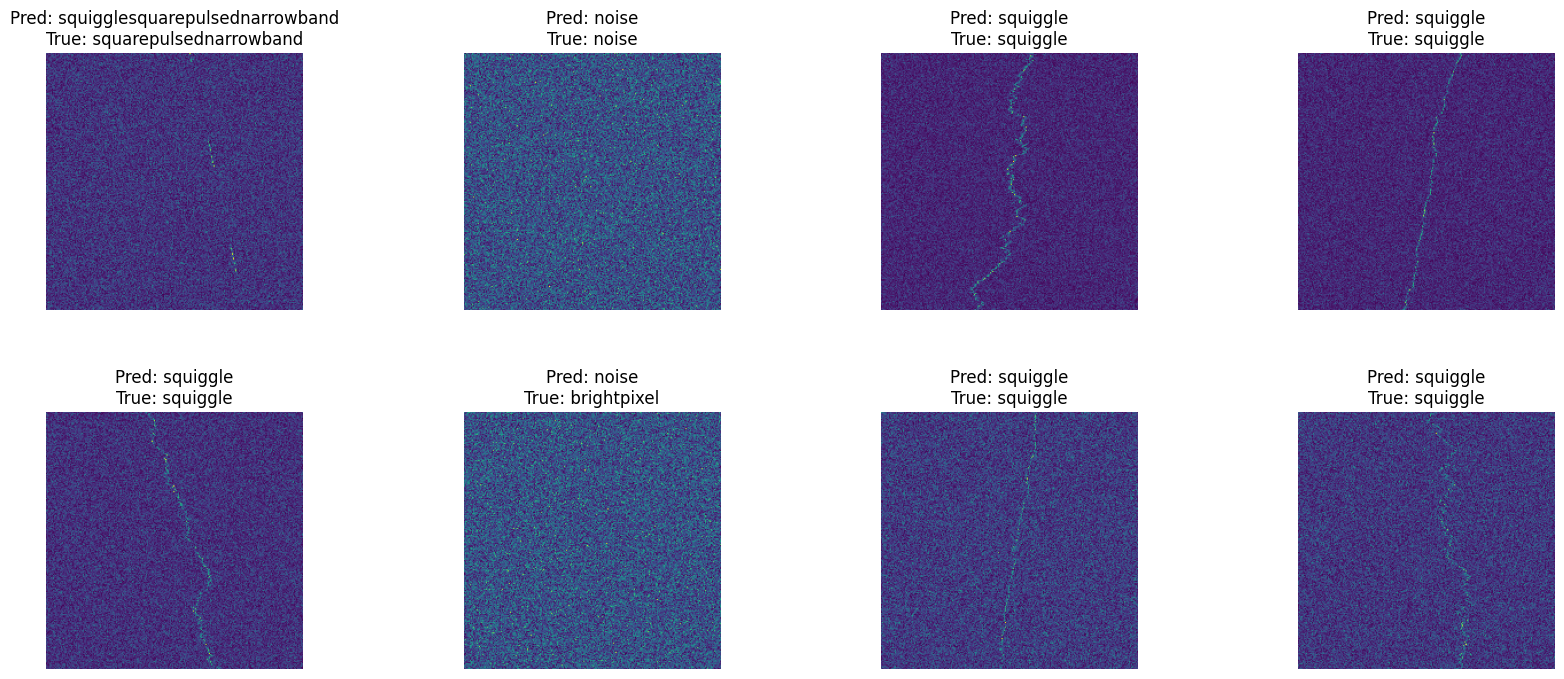

In [21]:
plot_predictions(model=vgg16_model, test_generator=test_generator, amount=8)

Although the visual results show significant improvement, with the model accurately predicting multiple classes, we cannot conclusively assess the model's effectiveness based on only a few samples. Therefore, we will continue to investigate and analyze the model in greater detail.

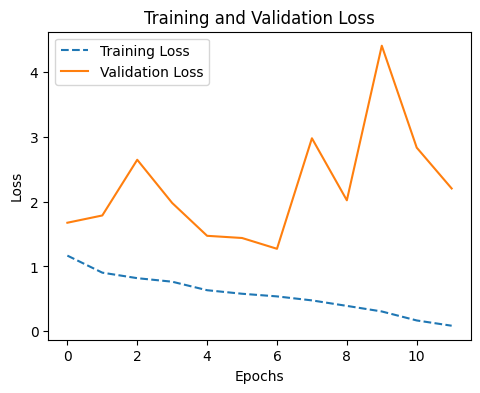

In [22]:
plot_losses(history)

Unfortunately, from this graph we can see a simptom of overfitting.  The fact that the validation loss fluctuates while the training loss continues to decrease indicates that overfitting. The model is likely learning the training data too well (including noise or less relevant features) but is struggling to generalize to unseen data (validation set).



22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step


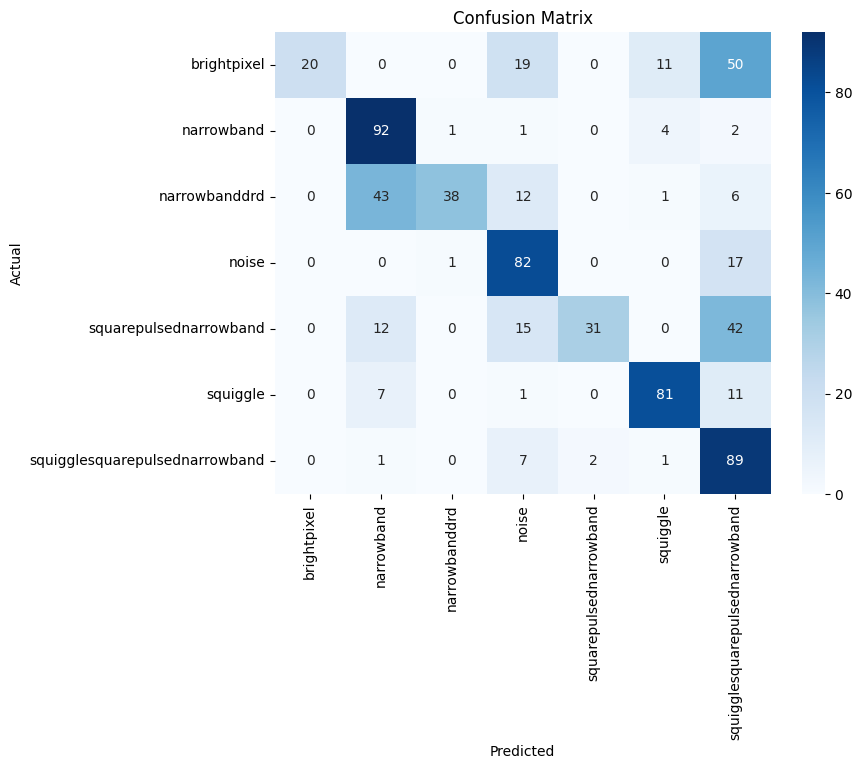

In [23]:
plot_confusion_matix(model=vgg16_model, test_generator=test_generator)

In [24]:
print_classifiaciton_report(model=vgg16_model, test_generator=test_generator)

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step
              precision  recall  f1-score  support
0                  1.00    0.20      0.33   100.00
1                  0.59    0.92      0.72   100.00
2                  0.95    0.38      0.54   100.00
3                  0.60    0.82      0.69   100.00
4                  0.94    0.31      0.47   100.00
5                  0.83    0.81      0.82   100.00
6                  0.41    0.89      0.56   100.00
accuracy           0.62    0.62      0.62     0.62
macro avg          0.76    0.62      0.59   700.00
weighted avg       0.76    0.62      0.59   700.00


Overall we can see that this model indeed performs better from ResNet50, but there are still some issues with it. We can see those issues from the confusion matix and the report above.  
At first, Class 0 ('brightpixel') has a a perfect precision (1.00), but low recall, which suggests that when the model predicts 'brightpixel', it is correct all of the time, but it's not predicting it very often, and to be more specific we can see it predicted it right only 20 times.
When looking into Class 6 ('squigglesquarepulsednarrowband') has a high recall (0.89), meaning most of the actual samples from this class were identified, but precision is low and the model confuses other classes with this class.

Data augmentation can potentially help improve our model's performance even more, especially in scenarios where the model struggles with specific classes.
So we will try enabling data augmentation and check out how the VGG16 will perform.

In [40]:
train_generator, valid_generator, test_generator = get_generated_data(data_aug=True)

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model with pretrained weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to use it as a feature extractor
base_model.trainable = False

# Unfreeze the last few layers of the pretrained model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Use base_model.output to get the output of the base model
x = base_model.output

# Add global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(2048, activation='relu')(x)

# Add batch normalization
x = BatchNormalization()(x)

# Output layer for 7 classes (for your SETI task)
output = Dense(7, activation='softmax')(x)

# Create the model
vgg16_model_with_data_aug = Model(inputs=base_model.input, outputs=output)

# Compile the model
vgg16_model_with_data_aug.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
start_time = time.time()

history = vgg16_model_with_data_aug.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
training_time = end_time - start_time
print(f'Model training time was: {training_time}')

Epoch 1/20


KeyboardInterrupt: 

We can observe that both the training accuracy and validation accuracy have significantly improved compared to previous results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


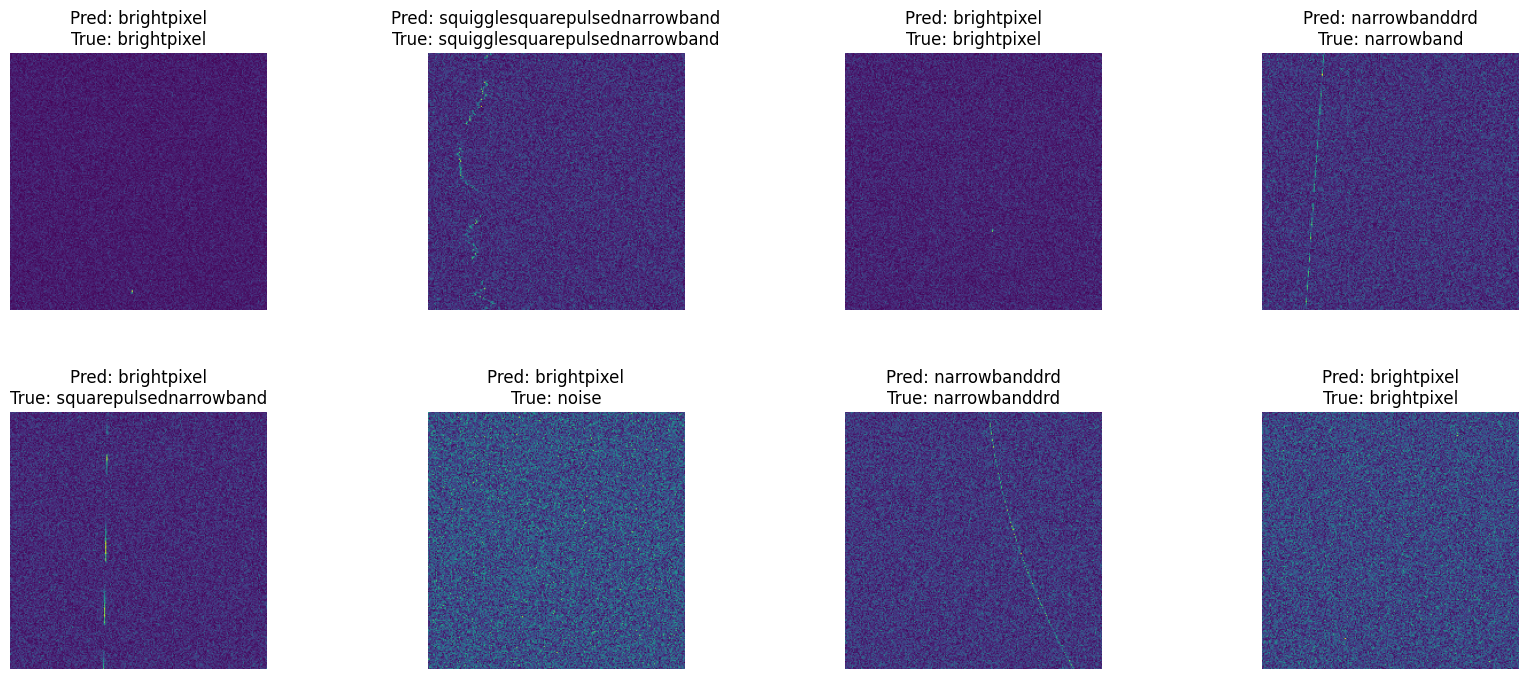

In [33]:
plot_predictions(model=vgg16_model_with_data_aug, test_generator=test_generator, amount=8)

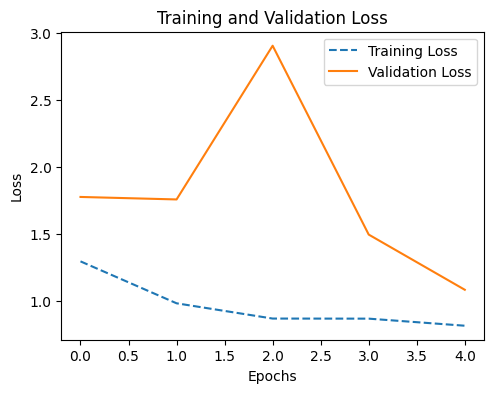

In [34]:
plot_losses(history)

We can finally see both training loss and validation loss decreasing.
Now let's take a look at the confusion matrix and the classification report, to see if the model's performance indeed improved.

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step


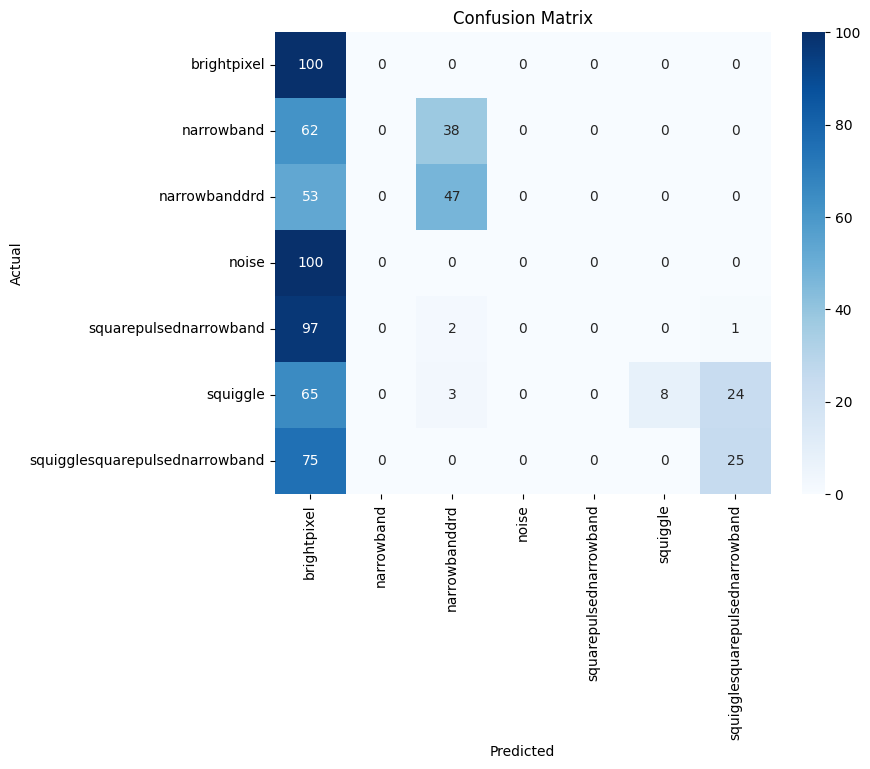

In [35]:
plot_confusion_matix(model=vgg16_model_with_data_aug, test_generator=test_generator)

In [ ]:
print_classifiaciton_report(model=vgg16_model_with_data_aug, test_generator=test_generator)

Based on the confusion matrix and the model's classification report, we observe an overall improvement in accuracy—68% compared to the previous 61%. This suggests that the data augmentation may have had a positive impact, despite some precision-recall trade-offs.

As mentioned earlier, the final layer of the model outputs a probability distribution across the different classes, assigning a likelihood that the input sample belongs to each class. While some predictions are made with high confidence, others, like in the example below, may show low confidence even when the prediction is correct.

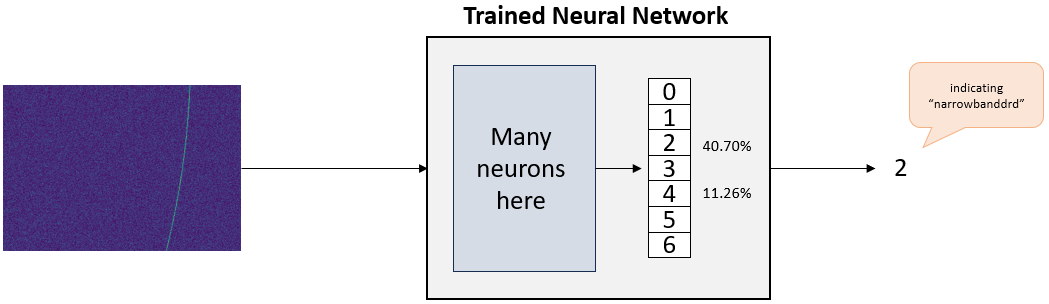

Low-confidence predictions, such as the one above, are not ideal. Although the model classified the sample correctly, its confidence was very low. To gain more insight into the model’s confidence in its decision-making process, we will explore its predictions alongside explanations using **SHAP (SHapley Additive exPlanations)**.

**What is SHAP?**  
SHAP is a powerful tool for interpreting machine learning models. It is based on game theory and uses Shapley values to explain how each feature of a model contributes to its predictions. In our case, SHAP helps explain which parts of the input image influenced the model’s decision the most, making it easier to understand the reasoning behind both high-confidence and low-confidence predictions.

SHAP can both provide an overall view of how the model makes decisions across the entire dataset, helping us identify the most important features that influence predictions and explains individual predictions by attributing a portion of the prediction score to each input feature (or pixel, in the case of images). This allows us to understand how the model arrives at a specific decision for a particular instance.

When visualizing shap values it shows explanations using color-coded feature attributions:

* Red pixels: These pixels increase the probability that a specific class is predicted. The more intense the red, the stronger their positive contribution to the prediction.
* Blue pixels: These pixels decrease the probability of a class being predicted, meaning they have a negative contribution to the prediction.

By approximating Shapley values, SHAP highlights how much each feature in the model (each pixel in image-based models) contributes to the prediction for a given sample. This gives us valuable insights into which regions of the image are driving the model's confidence.

In [ ]:
!pip install shap

In [ ]:
import shap

def plot_shap_and_probabilities(model, test_generator, amount=8, class_names = ["brightpixel", "narrowband", "narrowbanddrd", "noise", "squarepulsednarrowband", "squiggle", "squigglesquarepulsednarrowband"]):
    X_ts, _ = next(test_generator)
    masker = shap.maskers.Image("blur(128,128)", X_ts[0].shape)
    
    explainer = shap.Explainer(model, masker, output_names=class_names)

    for i in range(amount): 
        batch_index = np.random.randint(len(test_generator))

        # Extract a batch of data
        X_ts, y_ts = test_generator.__getitem__(batch_index)
        random_index = np.random.randint(test_generator.batch_size)

        shap_values = explainer(X_ts[random_index:random_index+1], max_evals=513, batch_size=32, outputs=shap.Explanation.argsort.flip[:7])
        shap.image_plot(shap_values)

        #The predictions array contains the probabilities for each class
        predicted_probabilities = model.predict(X_ts[random_index:random_index+1])

        # Get the predicted class
        predicted_class = np.argmax(predicted_probabilities[0])
        predicted_class_name = class_names[predicted_class]

        # Get the actual class label for the i-th sample
        actual_class = np.argmax(y_ts[random_index])  # Get the index of the actual class
        actual_class_name = class_names[actual_class]  # Convert index to class name

        # Print the predicted percentages and the actual class
        print(f"Predicted class: {predicted_class_name}, Actual class: {actual_class_name}")

        for class_name, percentage in zip(class_names,predicted_probabilities[0]*100): 
            print(f"{class_name}: {percentage:.2f}%", end=', ')


In [ ]:
plot_shap_and_probabilities(model=vgg16_model_with_data_aug, test_generator=test_generator)

Based on the samples above, we can observe that our model demonstrates a high level of confidence in its predictions, which is encouraging. Additionally, SHAP values allow us to understand the contributions of individual pixels to the model's decisions for each sample. Notably, it is fascinating to see that the model assigns higher SHAP values to regions it identifies as important.

When we visualize the SHAP values using **shap.image_plot**, especially with **outputs=shap.Explanation.argsort.flip[:7]** to display all seven classes, we can clearly see which regions of the samples the model considers as strong indicators for each class (highlighted in red) and which regions suggest that the sample does not belong to a given class (highlighted in blue). This provides a detailed understanding of how the model distinguishes between different classes based on specific image features.

The model `vgg16_model_with_data_aug` is actually not that bad giving us 80%, but we can do here something else for the final model. Up until now we have resized all of out images to the size of (224,224) and this is because the common use of image size 224x224 in many CNN architectures, like VGG16, ResNet, and manby others. Downscaling images can worsen the performance of a model in certain scenarios. This happens because when you reduce the size of an image, you also reduce the amount of detailed information available for the model to learn from and it may be the case in out scenario, so lets try one last time to train a model based on VGG with input of the original size of the images with data augmentation.

In [ ]:
from PIL import Image

im = Image.open("/kaggle/input/seti-data/primary_small/train/brightpixel/1103_brightpixel.png")
img_width, img_height = im.size
print((img_height, img_width))

In [ ]:
train_generator, valid_generator, test_generator = get_generated_data(img_height=img_height, img_width=img_width, data_aug=True)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model with pretrained weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model to use it as a feature extractor
base_model.trainable = False

# Unfreeze the last few layers of the pretrained model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Use base_model.output to get the output of the base model
x = base_model.output

# Add global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(2048, activation='relu')(x)

# Add batch normalization
x = BatchNormalization()(x)

# Output layer for 7 classes (for your SETI task)
output = Dense(7, activation='softmax')(x)

# Create the model
vgg16_model_with_data_aug_original_size = Model(inputs=base_model.input, outputs=output)

# Compile the model
vgg16_model_with_data_aug_original_size.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
vgg16_model_with_data_aug_original_size.summary()

In [ ]:
start_time = time.time()

history = vgg16_model_with_data_aug_original_size.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)


end_time = time.time()
training_time = end_time - start_time
print(f'Model training time was: {training_time}')

We can immidiatly see an improvment both in the training time and in the accuracy of the model.

In [ ]:
plot_predictions(model=vgg16_model_with_data_aug_original_size, test_generator=test_generator, amount=8)

In [ ]:
plot_losses(history)

This model exhibits a significantly faster decline in validation loss than the other models, indicating a quicker convergence during training.

In [ ]:
plot_confusion_matix(model=vgg16_model_with_data_aug_original_size, test_generator=test_generator)